## add guassian noise to the image

From $\boldsymbol{x}_{t-1}$ to $\boldsymbol{x}_t$, we can add some noise to the image. The noise is generated by the following equation:
$$\boldsymbol{x}_t = \sqrt{\alpha_t} \boldsymbol{x}_{t-1} + \sqrt{1-\alpha_t} \boldsymbol{\varepsilon}_t, \quad \boldsymbol{\varepsilon}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$$


also it's not hard to prove that from $\boldsymbol{x}_{0}$ to $\boldsymbol{x}_t$, we can also use the following equation to generate the noise:
$$\boldsymbol{x}_t =\sqrt{ \bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1- \bar{\alpha}_t}\bar{\boldsymbol{\varepsilon}}_t, \quad \bar{\boldsymbol{\varepsilon}}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}), \quad  \bar{\alpha}_t=\prod_{i=1}^t \alpha_i$$

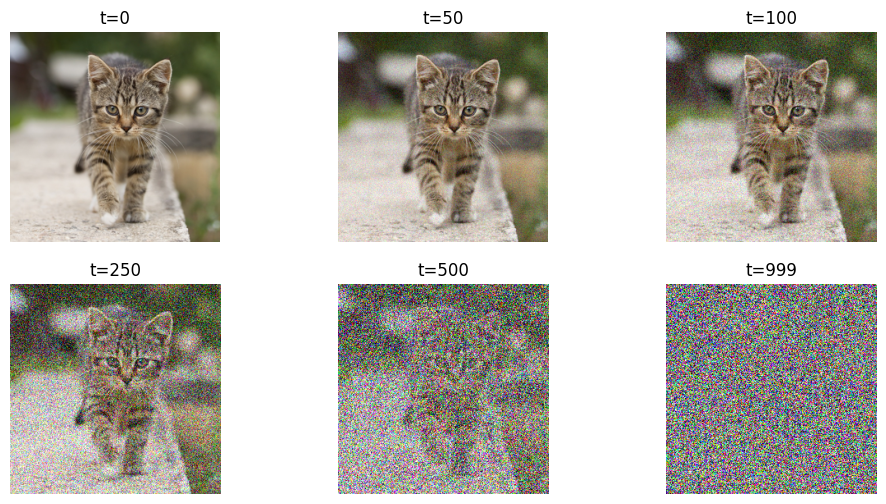

In [1]:
import torch
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange 

T = 1000

beta = 0.005 * torch.arange(1, T + 1) / T
alpha = 1 - beta
bar_alpha = torch.cumprod(alpha, 0)
sqrt_bar_alpha = torch.sqrt(bar_alpha)
sqrt_bar_beta = torch.sqrt(1 - bar_alpha)


def sample_x(x_0, t, sqrt_bar_alpha, sqrt_bar_beta, noise=None):
    if not noise: noise = torch.randn_like(x_0)
    shape = (x_0.shape[0], 1, 1, 1)
    return x_0 * sqrt_bar_alpha[t].view(shape) + noise * sqrt_bar_beta[t].view(shape), noise

## read image 
img = Image.open("./tiger_cat.jpg")
img = img.resize((256, 256))
img = (torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255 - 0.5) * 2
img = rearrange(img, 'c h w -> () c h w')

t_list = [0, 50, 100, 250, 500, 999]

x_list = []
for t in t_list:
    x, noise = sample_x(img, t, bar_alpha, sqrt_bar_beta)
    x = torch.clamp(x, -1, 1)
    x =  (x + 1) / 2
    x_list.append(x)

x_list = torch.cat(x_list, 0)
x_list = rearrange(x_list, 't c h w -> t h w c')

plt.figure(figsize=(12, 6))
for i, t in enumerate(t_list):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_list[i])
    plt.title(f"t={t}")
    plt.axis("off")
plt.show()


## conditioned distribution of:

$$\begin{aligned}     
q\left(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t, \boldsymbol{x}_0\right)     
    &=\frac{q\left(\boldsymbol{x}_t | \boldsymbol{x}_{t-1}, \boldsymbol{x}_0\right) q\left(\boldsymbol{x}_{t-1} | \boldsymbol{x}_0\right)}{q\left(\boldsymbol{x}_t | \boldsymbol{x}_0\right)}\\     
    &=\frac{q\left(\boldsymbol{x}_t | \boldsymbol{x}_{t-1}\right) q\left(\boldsymbol{x}_{t-1} | \boldsymbol{x}_0\right)}{q\left(\boldsymbol{x}_t | \boldsymbol{x}_0\right)}\\     
    &=\frac{\mathcal{N}\left(\boldsymbol{x}_t ; \sqrt{\alpha_t} \boldsymbol{x}_{t-1},\left(1-\alpha_t\right) \mathbf{I}\right) \mathcal{N}\left(\boldsymbol{x}_{t-1} ; \sqrt{\bar{\alpha}_{t-1}} \boldsymbol{x}_0,\left(1-\bar{\alpha}_{t-1}\right) \mathbf{I}\right)}{\mathcal{N}\left(\boldsymbol{x}_t ; \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right)}\\     

     &\propto \mathcal{N}\left(\boldsymbol{x}_{t-1} ; \underbrace{\frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right) \boldsymbol{x}_t+\sqrt{\bar{\alpha}_{t-1}}\left(1-\alpha_t\right) \boldsymbol{x}_0}{1-\bar{\alpha}_t}}_{\mu_q\left(\boldsymbol{x}_t, \boldsymbol{x}_0\right)}, \underbrace{\frac{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t}}_{\boldsymbol{\Sigma}_q(t)}\mathbf{I}\right)     
\end{aligned}$$

substitute $\boldsymbol{x}_0 = \frac{1}{\sqrt{ \bar{\alpha}_t}}(\boldsymbol{x}_t - \sqrt{1- \bar{\alpha}_t}\bar{\boldsymbol{\varepsilon}}_t)$ into above equation, we can get the following equation:

$$
\begin{aligned} \boldsymbol{\mu}_q        
&= \frac{1}{\sqrt{\alpha_t}} \boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t} \sqrt{\alpha_t}} \bar{\boldsymbol{\varepsilon}}_t   \end{aligned}$$

Because $\bar{\boldsymbol{\varepsilon}}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ is also, so we use symbol $\boldsymbol{\varepsilon}_t$ to substitute $\bar{\boldsymbol{\varepsilon}}_t$ in the following:
$$
\begin{aligned} \boldsymbol{\mu}_q        
&= \frac{1}{\sqrt{\alpha_t}} \boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t} \sqrt{\alpha_t}} {\boldsymbol{\varepsilon}}_t   \end{aligned} \\
\boldsymbol{x}_0 = \frac{1}{\sqrt{ \bar{\alpha}_t}}(\boldsymbol{x}_t - \sqrt{1- \bar{\alpha}_t}{\boldsymbol{\varepsilon}}_t)
$$

## By max likelihood estimation, $\theta$ is the parameter of the model:

$$\begin{aligned}       
\log p_\theta(\boldsymbol{x}_0)           
&=\log \int \frac{p_\theta(\boldsymbol{x}_{0: T}) q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)} d \boldsymbol{x}_{1: T} \\     &=\log \mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\frac{p_\theta(\boldsymbol{x}_{0: T})}{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\right] \\      
&\geq \mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p_\theta(\boldsymbol{x}_{0: T})}{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\right]\\     
&=\mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p(\boldsymbol{x}_T) \prod_{t=1}^T p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}{\prod_{t=1}^T q(\boldsymbol{x}_t | \boldsymbol{x}_{t-1})}\right]\\     
&=\mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p(\boldsymbol{x}_T) p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1) \prod_{t=2}^T p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}{q(\boldsymbol{x}_1 | \boldsymbol{x}_0) \prod_{t=2}^T q(\boldsymbol{x}_t | \boldsymbol{x}_{t-1})}\right]\\     
&=\mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p(\boldsymbol{x}_T) p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1) \prod_{t=2}^T p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}{q(\boldsymbol{x}_1 | \boldsymbol{x}_0) {\prod_{t=2}^T q(\boldsymbol{x}_t | \boldsymbol{x}_{t-1}, \boldsymbol{x}_0)}}\right]\\     
&=\mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p_{\theta}(\boldsymbol{x}_T) p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1)}{q(\boldsymbol{x}_1 | \boldsymbol{x}_0)}+\log \prod_{t=2}^T \frac{p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}{q(\boldsymbol{x}_t | \boldsymbol{x}_{t-1}, \boldsymbol{x}_0)}\right]\\     
&=\mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p(\boldsymbol{x}_T) p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1)}{q(\boldsymbol{x}_1 | \boldsymbol{x}_0)} +\log \prod_{t=2}^T \frac{p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}{{Red}{\frac{q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t, \boldsymbol{x}_0) q(\boldsymbol{x}_t | \boldsymbol{x}_0)}{q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_0)}}}\right] \\     
&= \mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p(\boldsymbol{x}_T) p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1)}{q(\boldsymbol{x}_1 | \boldsymbol{x}_0)} + \log \prod_{t=2}^T \frac{q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_0)} {q(\boldsymbol{x}_{t} | \boldsymbol{x}_0)} + \log \prod_{t=2}^T \frac{p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}{q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t, \boldsymbol{x}_0) }\right] \\     
&= \mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p(\boldsymbol{x}_T) p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1)}{q(\boldsymbol{x}_1 | \boldsymbol{x}_0)} + \log \frac{q(\boldsymbol{x}_{1} | \boldsymbol{x}_0)} {q(\boldsymbol{x}_{2} | \boldsymbol{x}_0)}\frac{q(\boldsymbol{x}_{2} | \boldsymbol{x}_0)} {q(\boldsymbol{x}_{3} | \boldsymbol{x}_0)}\dots \frac{q(\boldsymbol{x}_{T-1} | \boldsymbol{x}_0)} {q(\boldsymbol{x}_{T} | \boldsymbol{x}_0)} + \log \prod_{t=2}^T \frac{p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}{q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t, \boldsymbol{x}_0) }\right] \\     
&= \mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p(\boldsymbol{x}_T) p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1)}{q(\boldsymbol{x}_1 | \boldsymbol{x}_0)}+ \log \frac{q(\boldsymbol{x}_{1} | \boldsymbol{x}_0)} {q(\boldsymbol{x}_{T} | \boldsymbol{x}_0)}+ \log \prod_{t=2}^T \frac{p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}{q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t, \boldsymbol{x}_0) }\right] \\     
&=\mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p(\boldsymbol{x}_T) p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1)}{q(\boldsymbol{x}_1 | \boldsymbol{x}_0)}\frac{q(\boldsymbol{x}_1 | \boldsymbol{x}_0)}{q(\boldsymbol{x}_T | \boldsymbol{x}_0)}+\log \prod_{t=2}^T \frac{p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}{q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t, \boldsymbol{x}_0)}\right] \\     
&=\mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p(\boldsymbol{x}_T) p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1)}{q(\boldsymbol{x}_T | \boldsymbol{x}_0)}+\sum_{t=2}^T \log \frac{p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}{q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t, \boldsymbol{x}_0)}\right] \\ 
&=\mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1)\right]+\mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p(\boldsymbol{x}_T)}{q(\boldsymbol{x}_T | \boldsymbol{x}_0)}\right]+\sum_{t=2}^T \mathbb{E}_{q(\boldsymbol{x}_{1: T} | \boldsymbol{x}_0)}\left[\log \frac{p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}{q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t, \boldsymbol{x}_0)}\right] \\     
&=\mathbb{E}_{q(\boldsymbol{x}_1 | \boldsymbol{x}_0)}\left[\log p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1)\right]+\mathbb{E}_{q(\boldsymbol{x}_T | \boldsymbol{x}_0)}\left[\log \frac{p(\boldsymbol{x}_T)}{q(\boldsymbol{x}_T | \boldsymbol{x}_0)}\right]+\sum_{t=2}^T \mathbb{E}_{q(\boldsymbol{x}_{t-1}, \boldsymbol{x}_{t} | \boldsymbol{x}_0)}\left[\log \frac{p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}{q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t, \boldsymbol{x}_0)}\right] \\     
&=\mathbb{E}_{q(\boldsymbol{x}_1 | \boldsymbol{x}_0)}\left[\log p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1)\right]-\mathbb{E}_{q(\boldsymbol{x}_T | \boldsymbol{x}_0)}\left[\log \frac{q(\boldsymbol{x}_T | \boldsymbol{x}_0)}{p(\boldsymbol{x}_T)}\right]-\sum_{t=2}^T \mathbb{E}_{q(\boldsymbol{x}_{t}|  \boldsymbol{x}_0)}\mathbb{E}_{q(\boldsymbol{x}_{t-1}| \boldsymbol{x}_{t}, \boldsymbol{x}_0)}\left[\log \frac{q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t, \boldsymbol{x}_0)}{p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t)}\right] \\     
&=\underbrace{\mathbb{E}_{q(\boldsymbol{x}_1 | \boldsymbol{x}_0)}\left[\log p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1)\right]}_{\text {reconstruction term }}-\underbrace{D_{\mathrm{KL}}(q(\boldsymbol{x}_T | \boldsymbol{x}_0) \| p(\boldsymbol{x}_T))}_{\text {prior matching term }}-\sum_{t=2}^T \underbrace{\mathbb{E}_{q(\boldsymbol{x}_t | \boldsymbol{x}_0)}\left[D_{\mathrm{KL}}(q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t, \boldsymbol{x}_0) \| p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t))\right]}_{\text {denoising matching term }} 
\end{aligned}$$

## Minimize the above equation:
$$\begin{aligned}    
L_{VLB}   
&=-\underbrace{\mathbb{E}_{q(\boldsymbol{x}_1 | \boldsymbol{x}_0)}\left[\log p_{\theta}(\boldsymbol{x}_0 | \boldsymbol{x}_1)\right]}_{L_{0}}-\underbrace{D_{\mathrm{KL}}(q(\boldsymbol{x}_T | \boldsymbol{x}_0) \| p(\boldsymbol{x}_T))}_{L_{T}}-\sum_{t=2}^T \underbrace{\mathbb{E}_{q(\boldsymbol{x}_t | \boldsymbol{x}_0)}\left[D_{\mathrm{KL}}(q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t, \boldsymbol{x}_0) \| p_{\theta}(\boldsymbol{x}_{t-1} | \boldsymbol{x}_t))\right]}_{L_{t}} 
\end{aligned}
$$

Ho et al. 2020 models $L_{0} = \mathcal{N}(\boldsymbol{x}_0  ; \boldsymbol{\mu}_{\boldsymbol{\theta}}(\boldsymbol{x}_1, 1), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\boldsymbol{x}_1, 1))$

Parameterization for $L_{T}$:

$$
\begin{aligned}
p_{\boldsymbol{\theta}}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\boldsymbol{x}_t, t), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\boldsymbol{x}_t, t))
\end{aligned}
$$

We would like to train to predict $\boldsymbol{\mu}_q = \frac{1}{\sqrt{\alpha_t}} \boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t} \sqrt{\alpha_t}} \boldsymbol{\varepsilon}_t $, we want 
the network to predict $\boldsymbol{\varepsilon}_t $:

$$
\boldsymbol{\mu}_{\boldsymbol{\theta}}(\boldsymbol{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t} \sqrt{\alpha_t}} \boldsymbol{\varepsilon}_{\boldsymbol{\theta}}(\boldsymbol{x}_t, t) \\
\boldsymbol{\Sigma}_\theta(\boldsymbol{x}_t, t) = \boldsymbol{\Sigma}_q(t)
$$

$$
\begin{aligned}
D_{\mathrm{KL}}\left(\mathcal{N}\left(\boldsymbol{\mu}_q, \boldsymbol{\Sigma}_q\right) \| \mathcal{N}\left(\boldsymbol{\mu}_\theta, \boldsymbol{\Sigma}_\theta\right)\right) 
&= \frac{1}{2}\left[\log \frac{\left|\boldsymbol{\Sigma}_\theta\right|}{\left|\boldsymbol{\Sigma}_q\right|}-d+\operatorname{tr}\left(\boldsymbol{\Sigma}_\theta^{-1} \boldsymbol{\Sigma}_q\right)+\left(\boldsymbol{\mu}_\theta-\boldsymbol{\mu}_q\right)^T \boldsymbol{\Sigma}_\theta^{-1}\left(\boldsymbol{\mu}_\theta-\boldsymbol{\mu}_q\right)\right] \\
&= \underset{\boldsymbol{\theta}}{\arg \min } \frac{1}{2} \left[\left(\boldsymbol{\mu}_{\boldsymbol{\theta}}-\boldsymbol{\mu}_q\right)^T \boldsymbol{\Sigma}_q(t)^{-1}\left(\boldsymbol{\mu}_{\boldsymbol{\theta}}-\boldsymbol{\mu}_q\right)\right] \\
&= \underset{\boldsymbol{\theta}}{\arg \min } \boldsymbol{C} \left\| \boldsymbol{\varepsilon}_t - \boldsymbol{\varepsilon}_{\boldsymbol{\theta}}(\boldsymbol{x}_{t}, t) \right\|_{2}^2 \\
&= \underset{\boldsymbol{\theta}}{\arg \min } \boldsymbol{C} \left\| \boldsymbol{\varepsilon}_t - \boldsymbol{\varepsilon}_{\boldsymbol{\theta}}(\sqrt{ \bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1- \bar{\alpha}_t}{\boldsymbol{\varepsilon}}_t, t) \right\|_{2}^2
\end{aligned}
$$

![](ddpm_code.png)
![](sigma_t.png)

## Unet

![](unet.png)